![ramen_rj.png](https://github.com/rohinijagath/ramen-reviews/blob/main/ramen_rj.png?raw=true)

# Introduction
The Ramen Rater is a product review website for the hardcore ramen enthusiast (or "ramenphile"), with over 2500 reviews to date. This dataset is an export of "The Big List" (of reviews),
Each record in the dataset is a single ramen product review. Stars indicate the ramen quality, as assessed by the reviewer, on a 5-point scale; this is the most important column in the dataset.

This dataset was republished as-is from the original [BIG LIST](https://www.theramenrater.com/). The data set has since been updated to include reviews up until January 25th 2020 and currently reviews 3545 different ramen products.

# Import Packages

In [1]:
# general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import itertools
import time
import re
import pycountry_convert as pc

# visualizations
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

from sklearn.preprocessing import LabelEncoder, StandardScaler

C:\Users\User-PC\Documents\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
ramen = pd.read_csv('datasets_9366_13206_ramen-ratings.csv')
ramen.head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


# Data Description
## Data Structure & Types

The ramen review data comprises 2580 reviews or observations. Each review has the following fields:
- 'Review #' - unique identifier for each ramen product reviewed.
- 'Brand' - the Ramen brand
- 'Variety' - the name of the ramen product, indicative of the type, flavour and other defining characteristics.
- 'Style' - the type of packaging for the ramen product i.e. cup or pack.
- 'Country' - the country of production / origination
- 'Stars' - the rating provided by Hans Lienesch on the website https://www.theramenrater.com/.
- 'Top Ten' - indicates whether the product is in the top ten ramen reviews.

In [4]:
ramen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review #  2580 non-null   int64 
 1   Brand     2580 non-null   object
 2   Variety   2580 non-null   object
 3   Style     2578 non-null   object
 4   Country   2580 non-null   object
 5   Stars     2580 non-null   object
 6   Top Ten   41 non-null     object
dtypes: int64(1), object(6)
memory usage: 141.2+ KB


All data types seem appropriate with the exception of 'Stars' which should ideally be numeric instead of an object. Let's delve deeper into this ramen bowl.

## Data Completeness
### Style
The 'Style' is missing for two of the ramen products.

In [6]:
style = ramen[ramen['Style'].isnull()]
style

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
2152,428,Kamfen,E Menm Chicken,NaN,China,3.75,NaN
2442,138,Unif,100 Furong Shrimp,NaN,Taiwan,3,NaN


In [7]:
ramen.Style.mode()

0    Pack
dtype: object

The missing styles could be imputed by mode ('Pack'). Incidentally, when checked with the updated data set on the ramenrater.com, these two products are confirmed to come in a 'pack' form.

In [8]:
# fill null values for style
ramen['Style'].fillna('Pack', inplace=True)

# check for null values 
ramen.isnull().sum()

Review #       0
Brand          0
Variety        0
Style          0
Country        0
Stars          0
Top Ten     2539
dtype: int64

### Ratings
It appears that three of the ramen products featured in the data set are 'Unrated', hence the object data type.

In [10]:
# create df of unrated products
unrated = ramen[ramen['Stars'] == 'Unrated']
unrated

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
32,2548,Ottogi,Plain Instant Noodle No Soup Included,Pack,South Korea,Unrated,NaN
122,2458,Samyang Foods,Sari Ramen,Pack,South Korea,Unrated,NaN
993,1587,Mi E-Zee,Plain Noodles,Pack,Malaysia,Unrated,NaN


In [11]:
# filter out unrated ramen products
ramen = ramen[ramen['Stars'] != 'Unrated']

These entries will be dropped.

### Top Ten
The 'Top Ten' field indicates if a specific product was awarded a place on the annual top ten list.

In [12]:
# determine values of 
ramen['Top Ten'].value_counts()

\n          4
2014 #1     1
2015 #4     1
2016 #8     1
2016 #1     1
2015 #9     1
2013 #1     1
2013 #9     1
2012 #7     1
2013 #3     1
2016 #9     1
2013 #2     1
2012 #1     1
2012 #4     1
2014 #8     1
2014 #4     1
2013 #6     1
2015 #7     1
2014 #9     1
2014 #5     1
2013 #4     1
2013 #10    1
2012 #5     1
2014 #6     1
2012 #2     1
2015 #1     1
2015 #6     1
2015 #8     1
2012 #9     1
2016 #7     1
2012 #6     1
2016 #10    1
2014 #7     1
2012 #3     1
2012 #10    1
2015 #10    1
2016 #5     1
2014 #10    1
Name: Top Ten, dtype: int64

In [13]:
ramen['Top Ten'].isnull().sum()

2536

As the top ten list was awarded between 2012 and 2016 only and the majority of these entries are 'NaN'. The column will be dropped from the main dataframe

In [14]:
#drop 'Top Ten' from ramen df
ramen.drop(['Top Ten'], inplace=True, axis=1)

#drop null values
ramen.dropna(inplace=True)

In [15]:
ramen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2577 entries, 0 to 2579
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review #  2577 non-null   int64 
 1   Brand     2577 non-null   object
 2   Variety   2577 non-null   object
 3   Style     2577 non-null   object
 4   Country   2577 non-null   object
 5   Stars     2577 non-null   object
dtypes: int64(1), object(5)
memory usage: 140.9+ KB


# Feature Engineering
## Rating Category

In [16]:
# categorise no of ratings into groups using np.digitise
ramen = ramen.sort_values(by='Stars')
ramen['Stars'] = ramen.Stars.astype(float) 
bins = [0, 1, 2, 3, 4, 5]
names = ['<1', '1.0-1.99', '2.0-2.99', '3.0-3.99', '4.0-4.99', '5']
cat = dict(enumerate(names, 1))
ramen['category'] = np.vectorize(cat.get)(np.digitize(ramen['Stars'],
                                                        bins))

## Extracting Ramen Features from Description
Here I'll use string methods to determine whether a ramen product has a certain feature, for example: Hotness, Spiciness, and Type of Protein.

In [17]:
# extract features (hotness)
ramen['Hot'] = ramen.Variety.str.contains('Hot',na=False).astype(int)
ramen['Spicy'] = ramen.Variety.str.contains('Spicy',na=False).astype(int)
ramen['Curry'] = ramen.Variety.str.contains('Curry',na=False).astype(int)
ramen['Hot/Spicy'] = ramen['Hot'] + ramen['Spicy'] + ramen['Curry']
ramen['Hot/Spicy'].replace(2,1, inplace=True)
ramen['Hot/Spicy'].replace(3,1, inplace=True)

# protein types
ramen['Chicken'] = ramen.Variety.str.contains('Chicken',na=False).astype(int)
ramen['Beef'] = ramen.Variety.str.contains('Beef',na=False).astype(int)
ramen['Pork'] = ramen.Variety.str.contains('Pork',na=False).astype(int)

# seafood feature
ramen['Seafood'] = ramen.Variety.str.contains('Seafood',na=False).astype(int)
ramen['Shrimp'] = ramen.Variety.str.contains('Shrimp',na=False).astype(int)
ramen['Seafood'] = ramen['Seafood'] + ramen['Shrimp']
ramen.Seafood.replace(2,1, inplace=True)

# vegatables
# seafood feature
ramen['Vegetable'] = ramen.Variety.str.contains('Vegetable',na=False).astype(int)
ramen['Vegetarian'] = ramen.Variety.str.contains('Vegetarian',na=False).astype(int)
ramen['Vegetable'] = ramen['Vegetable'] + ramen['Vegetarian']
ramen.Vegetable.replace(2,1, inplace=True)

# drop unnecessary columns
ramen.drop(['Vegetarian', 'Shrimp', 'Hot', 'Spicy', 'Curry'], axis=1, inplace=True)

In [18]:
ramen.head()

,Review #,Brand,Variety,Style,Country,Stars,category,Hot/Spicy,Chicken,Beef,Pork,Seafood,Vegetable
557,2023,Urban Noodle,Authentic Street Food Black Bean,Cup,UK,0.0,<1,0,0,0,0,0,0
798,1782,Western Family,Beef Flavour Instant Noodles,Pack,Canada,0.0,<1,0,0,1,0,0,0
2537,43,Kim Ve Wong,Jaopai Series: Vegetarian Instant Noodles,Bowl,Taiwan,0.0,<1,0,0,0,0,0,1
563,2017,Samyang Foods,Honey & Cheese Big Bowl,Bowl,South Korea,0.0,<1,0,0,0,0,0,0
952,1628,Azami,Kimchee Noodle Soup,Cup,Canada,0.0,<1,0,0,0,0,0,0


# Exploratory Data Analysis
- Ramen Rating Groups
- Brands
- Variety
- Description Length
- Style
- Country
- Stars
- Top Ten

## Ramen Rating Groups

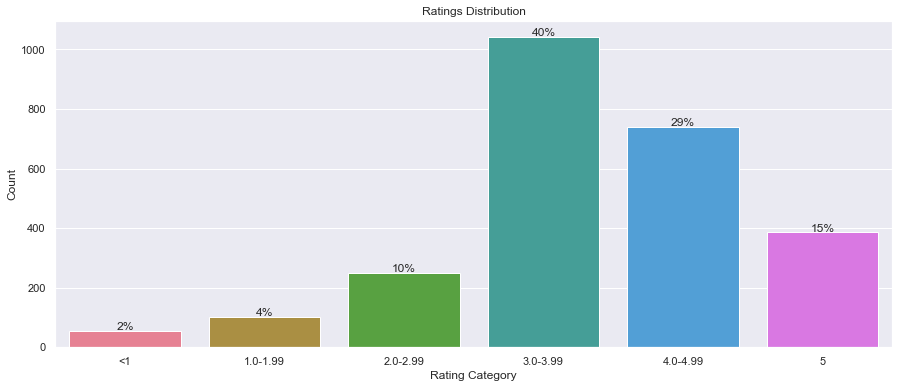

In [19]:
# create count plot of ratings distribution
sns.set()
plt.figure(figsize=(15, 6))
count = sns.countplot(x=ramen['category'], data=ramen.sort_values(by='Stars', inplace=True), palette="husl")
plt.xlabel('Rating Category')
plt.ylabel('Count')
plt.title('Ratings Distribution')

# calculate and display %
total = len(ramen)
for p in count.patches:
    height = p.get_height()
    count.text(p.get_x()+p.get_width()/2.,
               height + 3,
               '{:.0%}'.format(height/total),
               ha="center")

In [20]:
ramen.Stars.mode()

0    4.0
dtype: float64

#### Observations
- 2577 products are rated.
- The bulk of ramen products are given ratings above 3.0.
- The mean rating is 3.65. The most common rating is 4.0.
- It appears as though most ramen products appear to be satisfactory to good, with under 6% scoring less than 2.0 and 16% scoring less than 3.0

## Brands
### Top Ten Most Rated Overall

In [28]:
brands = pd.DataFrame({'count': ramen.groupby('Brand').size()}).reset_index()
brands = brands.sort_values(by = 'count')
fig = px.treemap(brands.tail(10), path=['Brand'], values='count', title="Rated Ramen Products by Brand")
fig.show()

In [29]:
del brands